# UBS_lauzhack - Entity resolution model

## 1. Pre-processing

Observed the given dataset and apply the proper transformations to the data in order to better anlyse it and create the model.

In [2]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
import warnings


InteractiveShell.ast_node_interactivity = "all"
#pd.set_option('precision', 3)
display.precision = 3
sns.set()
warnings.filterwarnings('ignore')

# extra imports
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
#from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox



In [3]:
# Read the CSV files from the 'data' subfolder
account_booking_df = pd.read_csv('data/account_booking_train.csv')
external_parties_df = pd.read_csv('data/external_parties_train.csv')

In [4]:
# Combine the tables with merge using 
combined_data = pd.merge(account_booking_df, external_parties_df, on='transaction_reference_id', how='inner')

In [5]:
#Null count of each variables to know which ones are more relevant to analyze
combined_data.isnull().sum()

transaction_reference_id            0
debit_credit_indicator              0
account_id                          0
transaction_amount                  0
transaction_currency                0
transaction_date                    0
party_role                          0
party_info_unstructured             0
parsed_name                         0
parsed_address_street_name        739
parsed_address_street_number     3030
parsed_address_unit             11064
parsed_address_postal_code       3480
parsed_address_city              1168
parsed_address_state             9107
parsed_address_country           6490
party_iban                       3399
party_phone                      5000
external_id                         0
dtype: int64

In [6]:
# Drop the columns that have more than 50% of missing values and irrelevant information

## External parties data

irrelevant_cols_external = ['party_info_unstructured', 'parsed_address_unit', 'parsed_address_state', 'parsed_address_country']
external_parties_df.drop(columns=irrelevant_cols_external, inplace=True, errors='ignore')

## Accounts booking data
duplicate_ids = account_booking_df[account_booking_df.duplicated(subset='transaction_reference_id', keep=False)]
account_booking_df = account_booking_df[~account_booking_df['transaction_reference_id'].isin(duplicate_ids['transaction_reference_id'])]

irrelevant_cols_booking = ['debit_credit_indicator']
account_booking_df.drop(columns=irrelevant_cols_booking, inplace=True, errors='ignore')

# Merge the two dataframes

merged_df = pd.merge(external_parties_df, account_booking_df, on='transaction_reference_id', how='inner')

merged_df.to_csv('merged_data_cleaned.csv', index=False)

### 1.1 Pre-processing of the variable parsed_name

In [7]:
# Delete honorifics from the names


def delete_honorifics(name): 
    name['parsed_name'] = name['parsed_name'].str.replace('Mr. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Ms. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Mrs. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Miss ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Dr. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Prof. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Rev. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('Hon. ', '')

    name['parsed_name'] = name['parsed_name'].str.replace('mr. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('ms. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('mrs. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('miss ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('dr. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('prof. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('rev. ', '')
    name['parsed_name'] = name['parsed_name'].str.replace('hon. ', '')

delete_honorifics(merged_df)
print(merged_df['parsed_name'])

0                 mary mith
1               yesneia kim
2           w. roberson jr.
3         azquez-nelson co.
4             m.j. bytd iii
                ...        
11059    james alvarado jr.
11060            marcnguyen
11061          joseph davis
11062           gonzalezltd
11063        simmons-conway
Name: parsed_name, Length: 11064, dtype: object


In [8]:
# Delete duplicates in the names

# Function to delete duplicated words in names
def delete_duplicates(name):
    def remove_duplicates(text):
        words = text.split()
        seen = set()
        result = []
        for word in words:
            if word.lower() not in seen:
                seen.add(word.lower())
                result.append(word)
        return ' '.join(result)
    
    name['parsed_name'] = name['parsed_name'].apply(remove_duplicates)

delete_duplicates(merged_df) 
print(merged_df['parsed_name'])

0                 mary mith
1               yesneia kim
2           w. roberson jr.
3         azquez-nelson co.
4             m.j. bytd iii
                ...        
11059    james alvarado jr.
11060            marcnguyen
11061          joseph davis
11062           gonzalezltd
11063        simmons-conway
Name: parsed_name, Length: 11064, dtype: object


In [9]:
import pandas as pd
import numpy as np
from metaphone import doublemetaphone

# Función para aplicar Metaphone
def apply_metaphone(value):
    if isinstance(value, list) or isinstance(value, np.ndarray):  
        return np.nan  
    if pd.isna(value) or not isinstance(value, str):  
        return np.nan
    return doublemetaphone(value.strip().lower())[0]  


def split_and_metaphone(full_name):
    """
    Divide un nombre completo en sus partes (palabras), aplica Metaphone a cada parte,
    y las junta nuevamente con espacios.
    """
    if pd.isna(full_name) or not isinstance(full_name, str):  
        return np.nan

    parts = full_name.strip().split()

    return ' '.join(apply_metaphone(part) for part in parts)

# Delete irrelevant columns

irrelevant_cols_external = ['party_info_unstructured', 'parsed_address_unit', 'parsed_address_state', 'parsed_address_country']
merged_df.drop(columns=irrelevant_cols_external, inplace=True, errors='ignore')

duplicate_ids = account_booking_df[account_booking_df.duplicated(subset='transaction_reference_id', keep=False)]
merged_df = merged_df[~merged_df['transaction_reference_id'].isin(duplicate_ids['transaction_reference_id'])]

irrelevant_cols_booking = ['debit_credit_indicator', 'transaction_amount', 'transaction_currency']
merged_df.drop(columns=irrelevant_cols_booking, inplace=True, errors='ignore')


# Apply Metaphone to the names and addresses

merged_df['parsed_name'] = merged_df['parsed_name'].apply(split_and_metaphone)

merged_df['parsed_address_street_name'] = merged_df['parsed_address_street_name'].apply(apply_metaphone)

merged_df.to_csv('merged_data_cleaned2.csv', index=False)

print(merged_df['parsed_name'].head(20))


0               MR M0
1              ASN KM
2           RPRSN JRR
3         ASKSSNLSN K
4           MMJJ PT A
5             FLRS LT
6         KRSTFR KTRS
7             KL KLRK
8       FLPS ANKRPRTT
9     KRR FXR ANT TRM
10          RPRSN JRR
11           MKL AKLR
12             ATM KL
13          MM STFNSN
14              SN RL
15            KNT PLK
16              KRMHN
17            TFT ARK
18           RMNT JNS
19            TMSSPKR
Name: parsed_name, dtype: object


### 1.2 Phone pre-processing

In [10]:
# Phone number normalization

combined_data['party_phone'] = combined_data['party_phone'].str.split('x').str[0]
combined_data['party_phone'] = combined_data['party_phone'].replace(r'\D', '', regex=True)
combined_data['party_phone'] = combined_data['party_phone'].str.lstrip('0')

data = combined_data[['party_phone']]
print(data)

          party_phone
0                 NaN
1        419477655328
2                 NaN
3       4119006262567
4                 NaN
...               ...
11059  13445497715686
11060   4116282024224
11061             NaN
11062             NaN
11063  51473539600789

[11064 rows x 1 columns]


## 2. Model?

In [11]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Load dataset

# test_accounts = pd.read_csv('account_booking_test.csv')
# test_external = pd.read_csv('external_parties_test.csv')

# combined_test = pd.merge(test_accounts, test_external, on='transaction_reference_id', how='inner')

# X_train = merged_df.drop(columns=['external_id'])
# X_test = combined_test

# y_train = merged_df['external_id']
# y_test = 0

print(merged_df['external_id'])

# Assuming merged_df is already defined and contains the 'external_id' column
# Convert categorical columns to numeric using Label Encoding
label_encoders = {}
for column in merged_df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    merged_df[column] = label_encoders[column].fit_transform(merged_df[column])

# Define features and target
X = merged_df.drop(columns=['external_id'])
y = merged_df['external_id']
print(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




0        50039037
1        60044692
2        30008244
3        40017944
4        40012658
           ...   
11059    35031814
11060    35003780
11061    30014262
11062    10359417
11063    10415954
Name: external_id, Length: 11064, dtype: int64
       transaction_reference_id  party_role  parsed_name  \
0                           220           0         3909   
1                          2973           1          900   
2                            38           1           24   
3                          9927           0          897   
4                          9036           1         3754   
...                         ...         ...          ...   
11059                      4960           0         1793   
11060                      7877           0         3955   
11061                      9307           1         2134   
11062                      8314           1         2653   
11063                      8477           0         5472   

       parsed_address_street_name 

      account_id  counts
5090       27750       9
2740       24146       9
5781       28824       8
4116       26256       8
729        21101       8
...          ...     ...
2949       24472       1
6546       29996       1
6541       29988       1
6540       29987       1
6538       29984       1

[6549 rows x 2 columns]
      parsed_name  counts
1833         1833      11
1640         1640      10
1961         1961       9
1926         1926       9
301           301       9
...           ...     ...
2527         2527       1
2526         2526       1
2525         2525       1
2524         2524       1
2534         2534       1

[6559 rows x 2 columns]
      parsed_address_street_name  counts
7473                        7473     739
3538                        3538      28
16                            16      26
903                          903      24
6052                        6052      22
...                          ...     ...
5                              5       1
4         

<Axes: xlabel='provi_id', ylabel='count'>

Text(0.5, 1.0, 'Count Plot of provi_id')

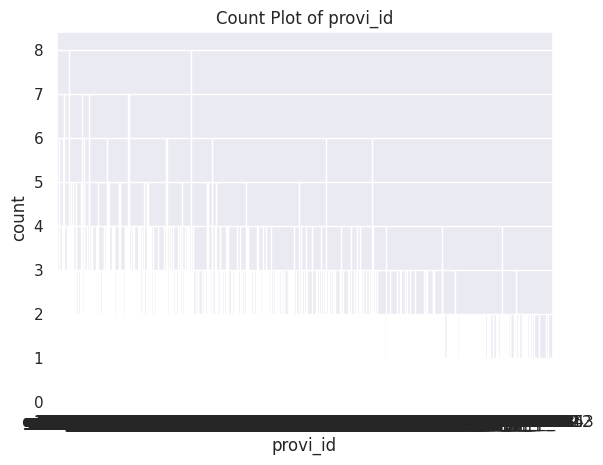

<Axes: xlabel='external_id', ylabel='count'>

Text(0.5, 1.0, 'Count Plot of external_id')

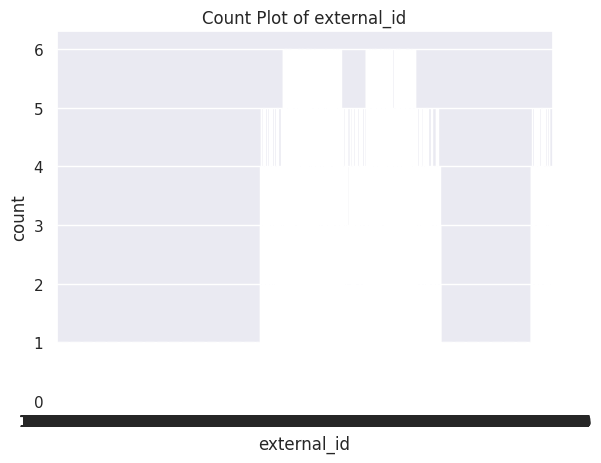

In [23]:
import networkx as nx

# Group by numbers of transactions

grouped_accounts = merged_df.groupby('account_id').size().reset_index(name='counts')
grouped_accounts = grouped_accounts.sort_values(by='counts', ascending=False)
print(grouped_accounts)

grouped_names = merged_df.groupby('parsed_name').size().reset_index(name='counts')
grouped_names = grouped_names.sort_values(by='counts', ascending=False)
print(grouped_names)

grouped_addresses = merged_df.groupby('parsed_address_street_name').size().reset_index(name='counts')
grouped_addresses = grouped_addresses.sort_values(by='counts', ascending=False)
print(grouped_addresses)

# Create a graph
G = nx.Graph()

# Add nodes for each transaction reference id
for idx, row in merged_df.iterrows():
    G.add_node(row['transaction_reference_id'], account_id=row['account_id'], parsed_name=row['parsed_name'], parsed_address_street_name=row['parsed_address_street_name'])

# Add edges based on grouped accounts
for _, row in grouped_accounts.iterrows():
    if row['counts'] <= 2:
        account_transactions = merged_df[merged_df['account_id'] == row['account_id']]['transaction_reference_id'].tolist()
        for i in range(len(account_transactions)):
            for j in range(i + 1, len(account_transactions)):
                G.add_edge(account_transactions[i], account_transactions[j], group='account')

# Add edges based on grouped names
for _, row in grouped_names.iterrows():
    if row['counts'] <= 2:
        name_transactions = merged_df[merged_df['parsed_name'] == row['parsed_name']]['transaction_reference_id'].tolist()
        for i in range(len(name_transactions)):
            for j in range(i + 1, len(name_transactions)):
                G.add_edge(name_transactions[i], name_transactions[j], group='name')

# Add edges based on grouped addresses
for _, row in grouped_addresses.iterrows():
    if row['counts'] <= 2 and row['counts'] < 739:
        address_transactions = merged_df[merged_df['parsed_address_street_name'] == row['parsed_address_street_name']]['transaction_reference_id'].tolist()
        for i in range(len(address_transactions)):
            for j in range(i + 1, len(address_transactions)):
                G.add_edge(address_transactions[i], address_transactions[j], group='address')

# Print the graph information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Nodes: {list(G.nodes(data=True))[:5]}")  # Print first 5 nodes with attributes
print(f"Edges: {list(G.edges(data=True))[:5]}")  # Print first 5 edges with attributes

# # Visualize the graph
# plt.figure(figsize=(12, 8))
# pos = nx.spring_layout(G, seed=42)  # positions for all nodes

# # Draw the nodes
# nx.draw_networkx_nodes(G, pos, node_size=50)

# # Draw the edges
# nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# # Draw the labels
# nx.draw_networkx_labels(G, pos, font_size=8)

# plt.title("Transaction Reference ID Graph")
# plt.show()

# Add a column 'provi_id' to the merged_df dataframe
merged_df['provi_id'] = None

# Assign 'provi_id' to nodes in each connected component
for i, component in enumerate(nx.connected_components(G)):
    for node in component:
        merged_df.loc[merged_df['transaction_reference_id'] == node, 'provi_id'] = f'group_{i}'

print(merged_df[['transaction_reference_id', 'provi_id']].head(20))

# Assign 'provi_id' to single nodes (nodes with no edges)
for node in G.nodes():
    if G.degree(node) == 0:
        merged_df.loc[merged_df['transaction_reference_id'] == node, 'provi_id'] = node


merged_df.to_csv('works_maybe.csv', index=False)

grouped_provi = merged_df.groupby('provi_id').size().reset_index(name='counts')
grouped_provi = grouped_provi.sort_values(by='counts', ascending=False)

print(grouped_provi)

import matplotlib.pyplot as plt


# Plot the counts of provi_id
sns.countplot(x='provi_id', data=merged_df)
plt.title('Count Plot of provi_id')
plt.show()

sns.countplot(x='external_id', data=merged_df)
plt.title('Count Plot of external_id')
plt.show()

In [13]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Sample data for demonstration
data = pd.DataFrame({
    'transaction_reference_id': [1, 2, 3, 4, 5],
    'parsed_name': ['John Doe', 'Jon Doe', 'Jane Doe', 'John Smith', 'Jane Smith'],
    'postal_code': ['12345', '12345', '67890', '12345', '67890'],
    'feature1': [10, 20, 30, 40, 50],
    'feature2': [1, 2, 3, 4, 5],
    'label': [0, 1, 0, 1, 0]
})

# Prepare the data
X = data[['feature1', 'feature2']]
y = data['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Predict
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 3
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 4, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

In [14]:

# Paso 3: Construcción del grafo
graph = nx.Graph()

# Agregar nodos
for idx, row in merged_data_cleaned2.iterrows():
    node_id = row['transaction_reference_id']
    graph.add_node(node_id, attributes=row)

# Agregar aristas basadas en similitud
for node1, node2 in possible_pairs:  # Comparar dentro de cada bloque
    sim_name = jaro_winkler_similarity(graph.nodes[node1]['attributes']['parsed_name'],
                                       graph.nodes[node2]['attributes']['parsed_name'])
    if sim_name > 0.8:
        graph.add_edge(node1, node2)

# Paso 4: Identificar componentes conexos
clusters = list(nx.connected_components(graph))

# Paso 5: Asignar IDs de cluster
cluster_mapping = {node: cluster_id for cluster_id, cluster in enumerate(clusters) for node in cluster}
data['external_id'] = data['transaction_reference_id'].map(cluster_mapping)




NameError: name 'merged_data_cleaned2' is not defined